In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [3]:
dataset = pd.read_csv('Data/FNN_data.csv')

#subtract the columns L_0_x, L_0_y, L_0_z from all the columns
# for i in range(0, 21):
#     dataset[f'L_{i}_x'] = dataset[f'L_{i}_x'] - dataset['L_0_x']
#     dataset[f'L_{i}_y'] = dataset[f'L_{i}_y'] - dataset['L_0_y']
#     # dataset[f'L_{i}_z'] = dataset[f'L_{i}_z'] - dataset['L_0_z']
#     dataset[f'R_{i}_x'] = dataset[f'R_{i}_x'] - dataset['R_0_x']
#     dataset[f'R_{i}_y'] = dataset[f'R_{i}_y'] - dataset['R_0_y']
#     # dataset[f'R_{i}_z'] = dataset[f'R_{i}_z'] - dataset['R_0_z']

# #write datatset to csv
# dataset.to_csv('Data/relative_data.csv', index=False)

X = dataset.iloc[:, 1:]
Y = dataset.iloc[:, 0]

# choose the columns which names do not end with z
X = X.loc[:, ~X.columns.str.endswith('z')]

# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

print(X_train)
print(Y_train)

       L_0_x  L_0_y     L_1_x     L_1_y     L_2_x     L_2_y     L_3_x  \
1921     0.0    0.0 -0.004820 -0.057607 -0.019342 -0.119619 -0.020058   
5732     0.0    0.0  0.030582 -0.068452  0.066033 -0.118453  0.098958   
2455     0.0    0.0 -0.013366 -0.054566 -0.039260 -0.100648 -0.047080   
12131    0.0    0.0  0.051912 -0.024143  0.091883 -0.071474  0.110770   
16612    0.0    0.0  0.035078 -0.014762  0.063324 -0.046080  0.070733   
...      ...    ...       ...       ...       ...       ...       ...   
11284    0.0    0.0  0.035475 -0.009871  0.065928 -0.036180  0.079373   
11964    0.0    0.0  0.029539 -0.025970  0.048853 -0.065543  0.044937   
5390     0.0    0.0  0.034163 -0.076962  0.064571 -0.136126  0.093768   
860      0.0    0.0  0.000843 -0.070633  0.034067 -0.136841  0.079285   
15795    0.0    0.0  0.054179 -0.018962  0.092692 -0.067662  0.117693   

          L_3_y     L_4_x     L_4_y  ...    R_16_x    R_16_y    R_17_x  \
1921  -0.143313 -0.001336 -0.115714  ... -0.00512

In [4]:
X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
Y_train_tensor = torch.tensor(Y_train.values).long()
Y_test_tensor = torch.tensor(Y_test.values).long()

print(X_train_tensor.shape)
print(Y_train_tensor.shape)


torch.Size([14400, 84])
torch.Size([14400])


In [5]:
batch_size = 64
n_iters = 10000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
test = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [13]:

class GestureFNN(torch.nn.Module):
    def __init__(self):
        super(GestureFNN, self).__init__()
        self.layer1 = torch.nn.Linear(84, 40)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.layer2 = torch.nn.Linear(40, 20)
        self.dropout2 = torch.nn.Dropout(0.4)
        self.layer3 = torch.nn.Linear(20, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [14]:
import torch.optim as optim

model = GestureFNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

model.train()

losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    total_batches = 0
    for i, (landmarks, labels) in enumerate(train_loader):
        landmarks = landmarks.to(device)
        labels = labels.to(device)

        outputs = model(landmarks)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches = i + 1

        losses.append(loss.item())

        # if (i+1) % 100 == 0:
            # print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

            # losses.append(running_loss/total_batches)
    
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {running_loss/total_batches:.4f}')

print('Finished Training')

cpu
Epoch: 1/44, Loss: 0.7343
Epoch: 2/44, Loss: 0.5574
Epoch: 3/44, Loss: 0.5546
Epoch: 4/44, Loss: 0.5536
Epoch: 5/44, Loss: 0.5532
Epoch: 6/44, Loss: 0.5528
Epoch: 7/44, Loss: 0.5530
Epoch: 8/44, Loss: 0.5528
Epoch: 9/44, Loss: 0.5526
Epoch: 10/44, Loss: 0.5526
Epoch: 11/44, Loss: 0.5526
Epoch: 12/44, Loss: 0.5523
Epoch: 13/44, Loss: 0.5524
Epoch: 14/44, Loss: 0.5523
Epoch: 15/44, Loss: 0.5524
Epoch: 16/44, Loss: 0.5522
Epoch: 17/44, Loss: 0.5524
Epoch: 18/44, Loss: 0.5524
Epoch: 19/44, Loss: 0.5521
Epoch: 20/44, Loss: 0.5522
Epoch: 21/44, Loss: 0.5521
Epoch: 22/44, Loss: 0.5524
Epoch: 23/44, Loss: 0.5522
Epoch: 24/44, Loss: 0.5521
Epoch: 25/44, Loss: 0.5521
Epoch: 26/44, Loss: 0.5519
Epoch: 27/44, Loss: 0.5520
Epoch: 28/44, Loss: 0.5519
Epoch: 29/44, Loss: 0.5520
Epoch: 30/44, Loss: 0.5518
Epoch: 31/44, Loss: 0.5518
Epoch: 32/44, Loss: 0.5518
Epoch: 33/44, Loss: 0.5518
Epoch: 34/44, Loss: 0.5517
Epoch: 35/44, Loss: 0.5517
Epoch: 36/44, Loss: 0.5517
Epoch: 37/44, Loss: 0.5517
Epoch:

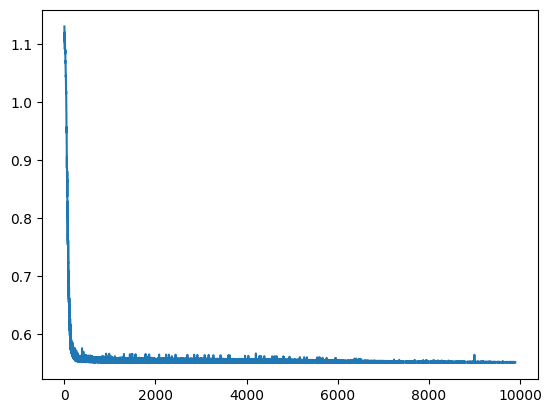

In [15]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()


In [19]:
with torch.no_grad():

    model.eval()

    correct = 0

    for i, (landmarks, labels) in enumerate(test_loader):
        landmarks = landmarks.to(device)
        labels = labels.to(device)

        print(landmarks.shape)
        outputs = model(landmarks)

        print(outputs.data)
        break

        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {correct / len(Y_test):.4f}')
    
# torch.save(model.state_dict(), 'Models/FNN_dropout.pth')


torch.Size([64, 84])
tensor([[1.0000e+00, 1.0250e-15, 4.9049e-17],
        [1.0000e+00, 8.9487e-16, 4.2579e-17],
        [1.8786e-29, 1.0000e+00, 7.7159e-27],
        [1.0000e+00, 6.8904e-21, 9.2900e-23],
        [1.0000e+00, 6.9611e-17, 2.3815e-18],
        [5.5478e-23, 1.0000e+00, 3.4285e-21],
        [1.0000e+00, 1.8032e-17, 5.4708e-19],
        [1.0000e+00, 1.3745e-15, 6.8467e-17],
        [8.0658e-18, 1.0000e+00, 1.1063e-16],
        [3.7435e-19, 1.0000e+00, 7.5474e-18],
        [8.1703e-28, 1.0000e+00, 2.0748e-25],
        [1.1600e-32, 1.0000e+00, 1.2213e-29],
        [1.8477e-20, 1.0000e+00, 5.4643e-19],
        [1.0000e+00, 7.5589e-16, 3.5310e-17],
        [1.0000e+00, 1.2270e-16, 4.6797e-18],
        [4.9545e-17, 1.0000e+00, 5.4391e-16],
        [1.0000e+00, 2.6787e-19, 5.3195e-21],
        [1.0000e+00, 7.8683e-18, 2.2415e-19],
        [1.0000e+00, 3.7240e-14, 2.6166e-15],
        [2.4121e-19, 1.0000e+00, 5.1418e-18],
        [9.7025e-23, 1.0000e+00, 5.6432e-21],
        [1.00

In [18]:
torch.save(model.state_dict(), 'Model/model.pth')